In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import pandas as pd
from torchvision.transforms.functional import to_pil_image
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
import itertools
import plotly.express as px
import plotly.graph_objects as go
import torch.nn.functional as F
import json
import random
from torch.utils.data import ConcatDataset
from PIL import Image

import medmnist
from medmnist import INFO, Evaluator

In [2]:
tqdm().disable = True

0it [00:00, ?it/s]

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on CPU


In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [5]:
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /home/rodrigo/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoi

In [8]:
# visualization

train_dataset.montage(length=1)

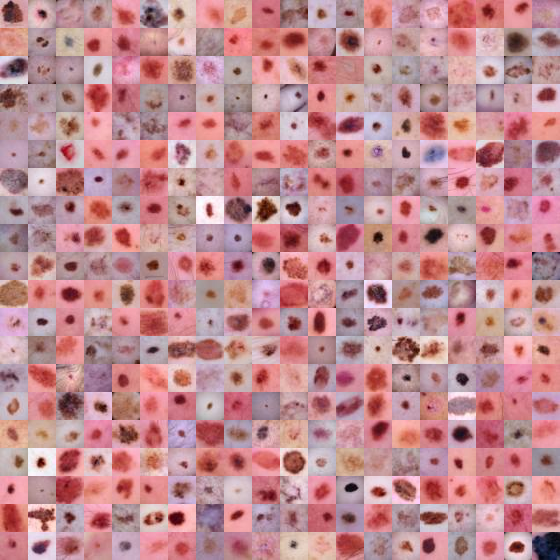

In [9]:
# montage

train_dataset.montage(length=20)

## Data Pre-processing

We will first check if the data is balanced:

In [10]:
train_labels = train_dataset.labels.squeeze()

fig = go.Figure()
fig.add_trace(go.Histogram(x=train_labels, name='train'))

# increase font size to 14
fig.update_layout(font=dict(size=16))

fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(range=[0, 5000])
fig.update_xaxes(title_text='Label')
fig.update_yaxes(title_text='Nº of samples')
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

As we can see, the dataset is heavily unbalanced. 

To fix this, we will start by performing data augmentation on the examples from the other classes in order to increase the number of examples from these classes.

We will then use random undersampling class to get a maximum of 1000 examples from each class.

In [11]:
def random_undersampling(dataset, n_samples_per_class):

    all_labels = np.array(dataset.labels.squeeze())
    unique_labels = np.unique(all_labels)

    undersampled_imgs = []
    undersampled_labels = []

    # Undersample each class
    for label in unique_labels:
        label_indices = np.where(all_labels == label)[0]

        if len(label_indices) > n_samples_per_class:
            label_indices = np.random.choice(label_indices, n_samples_per_class, replace=False)
        
        imgs = [dataset[i][0] for i in label_indices]
        undersampled_imgs.extend(imgs)
        undersampled_labels.extend([label] * len(imgs))
    
    # Shuffle the undersampled dataset
    indices = np.random.permutation(len(undersampled_imgs))
    undersampled_imgs = torch.tensor(np.array(undersampled_imgs)[indices])
    undersampled_labels = torch.tensor(np.array(undersampled_labels)[indices])

    return list(zip(undersampled_imgs, undersampled_labels))


# Apply random augmentation to the undersampled dataset
def augment_undersampled_dataset(dataset, n_samples_per_class=700):

    rotation = transforms.RandomRotation(30)
    translation = transforms.RandomAffine(0, translate=(0.1, 0.1))
    h_flip = transforms.RandomHorizontalFlip(p=1.0)  # Always apply
    v_flip = transforms.RandomVerticalFlip(p=1.0)  # Always apply

    augmented_imgs = []
    augmented_labels = []

    all_labels = []
    all_imgs = []
    
    for imgs, labels in dataset:
        all_imgs.append(imgs)
        all_labels.append(labels)

    all_labels = np.array(all_labels)
    unique_labels = np.unique(all_labels)

    for label in unique_labels:

        print(label)
        
        class_indices = np.where(all_labels == label)[0]
        class_imgs = [all_imgs[i] for i in class_indices]

        augmented_imgs_class = class_imgs.copy()


        while len(augmented_imgs_class) < n_samples_per_class:
            
            # Randomly select an image from the class
            img = random.choice(class_imgs)

            # Ensure img is a PIL image (if it's numpy, convert it)
            if isinstance(img, np.ndarray):
                img = Image.fromarray(img)  # Convert numpy array to PIL image

            # Randomly choose a transformation
            transformation = random.choice([rotation, translation, h_flip, v_flip])

            # Apply the transformation
            transformed_img = transformation(img)
            augmented_imgs_class.append(transformed_img)

        augmented_imgs.extend(augmented_imgs_class)
        augmented_labels.extend([label] * len(augmented_imgs_class))

    # Shuffle the augmented dataset
    indices = np.random.permutation(len(augmented_imgs))
    augmented_imgs = torch.tensor(np.array(augmented_imgs)[indices])
    augmented_labels = torch.tensor(np.array(augmented_labels)[indices])

    print(f"Augmented dataset size: {len(augmented_imgs)}")
    print(augmented_imgs[0].shape)

    return list(zip(augmented_imgs, augmented_labels))


In [12]:
undersampled_data = random_undersampling(train_dataset, 700)

In [13]:
labels = [label for _, label in undersampled_data]

fig = go.Figure()
fig.add_trace(go.Histogram(x=labels, name='undersampled'))

# increase font size to 14
fig.update_layout(font=dict(size=16))

fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(range=[0, 1100])
fig.update_xaxes(title_text='Label')
fig.update_yaxes(title_text='Nº of samples')
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

In [14]:
augmented_data = augment_undersampled_dataset(undersampled_data, 700)

0
1
2
3
4
5
6
Augmented dataset size: 4900
torch.Size([3, 28, 28])


In [15]:
labels = [label for _, label in augmented_data]

fig = go.Figure()
fig.add_trace(go.Histogram(x=labels, name='undersampled'))

# MLP

### Transform image into vector

#### 1. Flattening

In [16]:
# Stack input features
X_train = torch.stack([sample[0] for sample in augmented_data])
X_test = torch.stack([sample[0] for sample in test_dataset])

# Convert labels to 1D tensor
labels_train = [label for _,label in augmented_data]
y_train = torch.tensor(labels_train)
y_test = torch.tensor(test_dataset.labels.squeeze())

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

#### Get the MLPs

In [17]:
class DNN(nn.Module):

    def __init__(self, input_size, hidden_sizes, num_classes, activation):

        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

            if activation == 'relu':
                self.activations.append(nn.ReLU())
            elif activation == 'sigmoid':
                self.activations.append(nn.Sigmoid())
            elif activation == 'tanh':
                self.activations.append(nn.Tanh())
            else:
                raise ValueError(f"Unknown activation function: {activation}")
        
            for i in range(len(hidden_sizes)-1):

                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

                if activation == 'relu':
                    self.activations.append(nn.ReLU())
                elif activation == 'sigmoid':
                    self.activations.append(nn.Sigmoid())
                elif activation == 'tanh':
                    self.activations.append(nn.Tanh())
                else:
                    raise ValueError(f"Unknown activation function: {activation}")

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):

        for i in range(len(self.activations)):
            x = self.layers[i](x)  # Linear layer
            x = self.activations[i](x)  # Activation function
        
        x = self.layers[-1](x)
        
        return x
    

def fit(X_train, y_train, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=32):
    
    #send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device).long()

    # Train the network
    loss_values = []
    for epoch in range(n_epochs):

        accu_loss = 0

        for i in range(0, X_train.size(0), batch_size):

            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = nn(X_batch)
            loss = criterion(outputs, y_batch)
            accu_loss += loss.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, accu_loss))
        loss_values.append(accu_loss)

    return loss_values, nn.to("cpu")


def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    
    return conf_mat


In [18]:
parameters_test = {
    "n_epochs": [2],
    "batch_size": [32, 64],
    "learning_rate": [0.001, 0.01, 0.1],
    "n_layers": [3, 15],
    "activation_function": ['relu', 'sigmoid'],
    "loss_function": ["Cross Entropy", "Multi Margin"], #nn.CrossEntropyLoss(), nn.MultiMarginLoss()],
    "optimizer": ["ADAM", "SGD", "RMSprop"],
}

# Create a grid of hyperparameters
param_values = [v for v in parameters_test.values()]
param_names = [k for k in parameters_test.keys()]
param_combinations = list(itertools.product(*param_values))

In [207]:
# dict to store the results

results = {}
k = 5

# Loop over all hyperparameter combinations
for i, params in enumerate(param_combinations):

    print(f"Testing hyperparameter combination {i+1}/{len(param_combinations)}")
    print(params)
    param_dict = dict(zip(param_names, params))

    results[i] = {**param_dict, "results": []}

    # Unpack the parameters
    n_epochs, batch_size, learning_rate, n_layers, activation_function, loss_function, optimizer_name = params
    num_inputs = X_train_flattened.shape[1]

    hidden_layers_sizes = ((num_inputs + n_classes) // 2,) * n_layers
    total_data_train = X_train_flattened.shape[0]
    total_data_fold = total_data_train // k

    for fold in range(k):

        idxs_val_fold = list(range(fold*total_data_fold, (fold+1)*total_data_fold))
        idxs_train_fold = list(set(range(total_data_train)) - set(idxs_val_fold))

        X_val_flattened_fold = X_train_flattened[idxs_val_fold]
        y_val_fold = y_train[idxs_val_fold]

        X_train_flattened_fold = X_train_flattened[idxs_train_fold]
        y_train_fold = y_train[idxs_train_fold]

        # Define the network
        dnn = DNN(input_size = num_inputs,
                hidden_sizes = hidden_layers_sizes, 
                num_classes = n_classes, 
                activation = activation_function)

        # Define the loss function and optimizer
        if loss_function == "Cross Entropy":
            criterion = nn.CrossEntropyLoss()
        elif loss_function == "Multi Margin":
            criterion = nn.MultiMarginLoss()
        else:
            raise ValueError(f"Unknown loss function: {loss_function}")
        
        if optimizer_name == "ADAM":
            optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(dnn.parameters(), lr=learning_rate)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(dnn.parameters(), lr=learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")

        # Train the network
        loss_values, trained_net = fit(X_train_flattened_fold, 
                                    y_train_fold.long(), 
                                    dnn,
                                    criterion,
                                    optimizer,
                                    n_epochs = n_epochs, 
                                    batch_size = batch_size, 
                                    to_device = False)

        # Evaluate the network
        conf_mat_train = evaluate_network(trained_net, X_train_flattened_fold, y_train_fold)
        conf_mat = evaluate_network(trained_net, X_val_flattened_fold, y_val_fold)

        # Store the results
        results[i]["results"].append({
            'loss_values': loss_values,
            'confusion_matrix_train': conf_mat_train.tolist(),
            'confusion_matrix_val': conf_mat.tolist()
        })

    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)

Testing hyperparameter combination 1/144
(2, 32, 0.001, 3, 'relu', 'Cross Entropy', 'ADAM')
Epoch [1/2], Loss: 326.1632
Epoch [2/2], Loss: 309.7834
Epoch [1/2], Loss: 325.9045
Epoch [2/2], Loss: 313.9800
Epoch [1/2], Loss: 324.6772
Epoch [2/2], Loss: 311.6850
Epoch [1/2], Loss: 325.6764
Epoch [2/2], Loss: 313.5572
Epoch [1/2], Loss: 325.0232
Epoch [2/2], Loss: 315.4541
Testing hyperparameter combination 2/144
(2, 32, 0.001, 3, 'relu', 'Cross Entropy', 'SGD')
Epoch [1/2], Loss: 340.4442
Epoch [2/2], Loss: 340.0519
Epoch [1/2], Loss: 340.4513
Epoch [2/2], Loss: 340.0807
Epoch [1/2], Loss: 340.2573
Epoch [2/2], Loss: 339.8776
Epoch [1/2], Loss: 340.3644
Epoch [2/2], Loss: 340.0079
Epoch [1/2], Loss: 340.5029
Epoch [2/2], Loss: 340.1136
Testing hyperparameter combination 3/144
(2, 32, 0.001, 3, 'relu', 'Cross Entropy', 'RMSprop')
Epoch [1/2], Loss: 1005.2509
Epoch [2/2], Loss: 320.4331
Epoch [1/2], Loss: 1359.5396
Epoch [2/2], Loss: 320.3771
Epoch [1/2], Loss: 1583.9283
Epoch [2/2], Loss: 

KeyboardInterrupt: 

In [193]:

class CNN(nn.Module):

    def __init__(self, num_conv_layers, conv_out_channels,
                 conv_kernel_size, conv_padding, num_hidden_layers, 
                 activation_function, pooling, input_channels, num_classes):
        
        """
        Fully configurable CNN model
        
        Args:
        - input_channels (int): Number of input channels (e.g., 3 for RGB).
        - num_classes (int): Number of output classes.
        - num_conv_layers (int): Number of convolutional layers.
        - conv_out_channels (int): Number of output channels for each conv layer.
        - conv_kernel_size (int): Kernel size for convolutional layers.
        - conv_padding (int): Padding for convolutional layers.
        - num_hidden_layers (int): Number of fully connected hidden layers.
        - activation_function: Activation function
        - pooling (nn.Module): Pooling layer
        """

        super(CNN, self).__init__()

        self.activation = activation_function
        self.pooling = pooling

        # Create convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels

        for _ in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, conv_out_channels, kernel_size=conv_kernel_size, padding=conv_padding))
            in_channels = conv_out_channels

        feature_size = self._compute_flattened_size(28, num_conv_layers, conv_kernel_size, conv_padding)

        self.fc_layers = nn.ModuleList()
        fc_input_size = feature_size

        # in here we are assuming all fully connected layers will have the same size - done in order to be consistent with dnn
        for _ in range(num_hidden_layers):
            self.fc_layers.append(nn.Linear(fc_input_size, fc_input_size))

        self.output_layer = nn.Linear(fc_input_size, num_classes)


    def _compute_flattened_size(self, input_size, num_conv_layers, kernel_size, padding):

        """ Helper function to compute the flattened size after convolutions """
        for _ in range(num_conv_layers):
            input_size = (input_size - kernel_size + 2 * padding) + 1  # Conv effect
            input_size //= 2  # Max pooling effect
        return input_size * input_size * self.conv_layers[-1].out_channels


    def forward(self, x):

        for conv in self.conv_layers:
            x = self.pooling(self.activation(conv(x)))
        
        x = x.view(x.shape[0], -1)

        for fc in self.fc_layers:
            x = self.activation(fc(x))
        
        x = self.output_layer(x)
        return x

In [ ]:
parameters_test_cnn = {
    "n_epochs": [50],
    "activation_function": ['relu', 'sigmoid'],
    "pooling": [nn.MaxPool2d(2), nn.AvgPool2d(2)],
    "n_conv_layers": [1, 2],
    "conv_out_channels": [16],
    "conv_kernel_size": [3],
    "conv_padding": [1],
    "n_layers": [3, 15],
    "batch_size": [32, 64],
    "learning_rate": [0.001, 0.01, 0.1],
    "loss_function": ["Cross Entropy", "Multi Margin"], #[nn.CrossEntropyLoss(), nn.MultiMarginLoss()],
    "optimizer": ["ADAM", "SGD", "RMSprop"],
}

# Create a grid of hyperparameters
param_values = [v for v in parameters_test_cnn.values()]
param_names = [k for k in parameters_test_cnn.keys()]
param_combinations = list(itertools.product(*param_values))
total_combinations = len(param_combinations)

In [ ]:
results = {}

for i, params in tqdm(enumerate(param_combinations), total=total_combinations, desc="Hyperparameter Search"):

    print(f"\nTesting combination {i+1}/{total_combinations}")
    param_dict = dict(zip(param_names, params))
    print(param_dict)

    results[i] = {**param_dict, "results": []}

    if param_dict["activation_function"] == "relu":
        activation = nn.ReLU()
    elif param_dict["activation_function"] == "sigmoid":
        activation = nn.Sigmoid()
    else:
        raise ValueError(f"Unknown activation function: {param_dict['activation_function']}")
    
    total_data_train = X_train.shape[0]
    total_data_fold = total_data_train // k

    for fold in range(k):

        idxs_val_fold = list(range(fold*total_data_fold, (fold+1)*total_data_fold))
        idxs_train_fold = list(set(range(total_data_train)) - set(idxs_val_fold))

        X_val_fold = X_train[idxs_val_fold]
        y_val_fold = y_train[idxs_val_fold]

        X_train_fold = X_train[idxs_train_fold]
        y_train_fold = y_train[idxs_train_fold]

        # Define the network
        cnn = CNN(
            input_channels = 3,
            num_classes = n_classes,
            num_conv_layers = param_dict["n_conv_layers"],
            conv_out_channels=param_dict["conv_out_channels"],
            conv_kernel_size=param_dict["conv_kernel_size"],
            conv_padding=param_dict["conv_padding"],
            activation_function=activation,
            pooling=param_dict["pooling"],
            num_hidden_layers=param_dict["n_layers"],
        )

        # Define loss function and optimizer

        if param_dict["loss_function"] == "Cross Entropy":
            criterion = nn.CrossEntropyLoss()
        elif param_dict["loss_function"] == "Multi Margin":
            criterion = nn.MultiMarginLoss()
        else:
            raise ValueError(f"Unknown loss function: {loss_function}")
        
        optimizer = {
            "ADAM": optim.Adam(cnn.parameters(), lr=param_dict["learning_rate"]),
            "SGD": optim.SGD(cnn.parameters(), lr=param_dict["learning_rate"]),
            "RMSprop": optim.RMSprop(cnn.parameters(), lr=param_dict["learning_rate"]),
        }[param_dict["optimizer"]]

        # Train the network
        loss_values, trained_net = fit(X_train_fold,
                                    y_train_fold.long(), 
                                    cnn, 
                                    criterion, 
                                    optimizer, 
                                    param_dict["n_epochs"], 
                                    param_dict["batch_size"])

        # Evaluate the network
        conf_mat_train = evaluate_network(trained_net, X_train_fold, y_train_fold)
        conf_mat_val = evaluate_network(trained_net, X_val_fold, y_val_fold)

        # Store results
        results[i]["results"].append({
            'loss_values': loss_values,
            'confusion_matrix_train': conf_mat_train.tolist(),
            'confusion_matrix_val': conf_mat_val.tolist(),
        })

    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)


Hyperparameter Search:   0%|          | 0/576 [00:00<?, ?it/s]


Testing combination 1/576
{'n_epochs': 1, 'activation_function': 'relu', 'pooling': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 'n_conv_layers': 1, 'conv_out_channels': 16, 'conv_kernel_size': 3, 'conv_padding': 1, 'n_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, 'loss_function': CrossEntropyLoss(), 'optimizer': 'ADAM'}
Epoch [1/1], Loss: 328.9199
Epoch [1/1], Loss: 311.5955


Hyperparameter Search:   0%|          | 0/576 [02:39<?, ?it/s]


KeyboardInterrupt: 